# Data generation performance & comparison
Data loading and generation is important because we want to have as many images processed as possible
There are several ways to do this within the Tensorflow environment. The focus is to make a trade off between flexibility (decreasing the amount of img/min processed, and speed which decreases flexibility).
The following approaches can be made:

* Using Keras ImageDataGenerator: this is easy but slow (a crucial point in this challenge)
* The ImageDataGenerator wrapped in tf data.from_generator (even slower, I want to avoid this)
* Pure tensorflow (Less flexible, but sometimes 10x faster)

The comparison between these methods is made here:
https://www.tensorflow.org/tutorials/load_data/images

Now that the Tensorflow approach is chosen, we can make another division:
1. Create a general generator that accepts .tiff images as input, which can then be processed (concat tile pooling) in a flexible way
2. Create a generator based on the already concat tile processed png images.

For now, I stick with the second option, knowing that I will probably make the first one a bit later onwards

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from pprint import pprint
import pandas as pd
from glob import glob
import skimage.io
import sys
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer
import time

print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

sys.path.insert(0,'..')
from utils.data_utils import DataLoaderPNG
from utils.utils import set_gpu_memory

DATA_DIR = Path('../data/')
set_gpu_memory(device_type='GPU')


/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.3.0-dev20200513). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


2.3.0-dev20200513
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Today:
~~create train/val split~~  
Generalize train/val to KFold training   
create a basic data augmentation   
Image preprocessing   
~~Alter network top with more layers~~   
Make a second model that chains two models   

## Directory processing

In [2]:
DATA_DIR = '../data'
IMG_DIR = '../data/train'
TRAIN_MASKS_DIR = '../data/masks'
train_csv = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
SEED=5

# probably images with pen mark
#noise_csv = pd.read_csv('../input/noisy-csv/suspicious_test_cases.csv')

#for image_id in noise_csv['image_id'].values:
#    train_csv = train_csv[train_csv['image_id'] != image_id]

radboud_csv = train_csv[train_csv['data_provider'] == 'radboud']
karolinska_csv = train_csv[train_csv['data_provider'] != 'radboud']
radboud_csv

,image_id,data_provider,isup_grade,gleason_score
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
12,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3
15,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3
18,007433133235efc27a39f11df6940829,radboud,0,negative
...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
10613,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative
10614,ffe236a25d4cbed59438220799920749,radboud,2,3+4


## Create folds for K fold validation

In [3]:
masks_ids = os.listdir(DATA_DIR / Path('train_label_masks'))
masks_ids = [x.split('_')[0] for x in masks_ids]
masks_ids = pd.DataFrame({'image_id': masks_ids})

splits = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
splits = list(splits.split(radboud_csv, radboud_csv.isup_grade))
fold_splits = np.zeros(len(radboud_csv)).astype(np.int)

for i in range(5): 
    fold_splits[splits[i][1]]=i
radboud_csv['fold'] = fold_splits
display(radboud_csv.head(5))


splits = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
splits = list(splits.split(karolinska_csv, karolinska_csv.isup_grade))
fold_splits = np.zeros(len(karolinska_csv)).astype(np.int)
for i in range(5): 
    fold_splits[splits[i][1]]=i
karolinska_csv['fold'] = fold_splits
karolinska_csv.head(5)

train_csv = pd.concat([radboud_csv, karolinska_csv])
train_csv = pd.merge(train_csv, masks_ids)
train_csv.shape


/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,image_id,data_provider,isup_grade,gleason_score,fold
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
12,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3,4
15,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3,2
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,1
18,007433133235efc27a39f11df6940829,radboud,0,negative,2


/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(10516, 5)

In [4]:
# dunno what this is for yet (probably tensorflow loop training)
TRAIN_FLAG=False
TRAIN_FOLD = 0

In [5]:
train_df = train_csv[train_csv['fold'] != TRAIN_FOLD]
valid_df = train_csv[train_csv['fold'] == TRAIN_FOLD]

display(train_df)
display(valid_df)

print(train_df.shape)
print(valid_df.shape)

,image_id,data_provider,isup_grade,gleason_score,fold
0,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
1,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3,4
2,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3,2
3,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,1
4,007433133235efc27a39f11df6940829,radboud,0,negative,2
...,...,...,...,...,...
10511,ffbe854e810d4e4db8fc4acb3ac15333,karolinska,2,3+4,2
10512,ffc005d56a21efbd034425623f596984,karolinska,2,3+4,2
10513,ffc0cbbe28a6345a179d6210ef5c579f,karolinska,4,4+4,1
10514,ffcd99c47e57ad2934dc6bbf5edf6675,karolinska,0,0+0,2


,image_id,data_provider,isup_grade,gleason_score,fold
6,008069b542b0439ed69b194674051964,radboud,4,4+4,0
10,00a7fb880dc12c5de82df39b30533da9,radboud,3,4+3,0
11,00bbc1482301d16de3ff63238cfd0b34,radboud,2,3+4,0
21,010dea54bfd0a4a1eb1c0719949bb4a4,radboud,5,5+4,0
25,01642d24ac5520681d6a20f6c42dc4fe,radboud,0,negative,0
...,...,...,...,...,...
10481,fe8e6d622955498e6d221940363f57b4,karolinska,0,0+0,0
10488,fedd0914fb849d76b0fe96e1683bbe55,karolinska,0,0+0,0
10503,ff596d5292ab979e9ba7291d0743b3fb,karolinska,0,0+0,0
10508,ff97fa212a451432b685bdad1c3c89df,karolinska,2,3+4,0


(8406, 5)
(2110, 5)


## Training parameters

In [6]:
IMG_DIM = (128, 128)
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS = 15
NUM_TILES=16


LEARNING_RATE = 1e-4
FOLDED_NUM_TRAIN_IMAGES = train_df.shape[0]
FOLDED_NUM_VALID_IMAGES = valid_df.shape[0]
STEPS_PER_EPOCH = FOLDED_NUM_TRAIN_IMAGES // BATCH_SIZE
VALIDATION_STEPS = FOLDED_NUM_VALID_IMAGES // BATCH_SIZE

In [7]:
print('*'*20)
print('Notebook info')
print('Training data : {}'.format(FOLDED_NUM_TRAIN_IMAGES))
print('Validing data : {}'.format(FOLDED_NUM_VALID_IMAGES))
print('Categorical classes : {}'.format(NUM_CLASSES))
print('Training image size : {}'.format(IMG_DIM))
print('Training epochs : {}'.format(NUM_EPOCHS))
print('*'*20)

********************
Notebook info
Training data : 8406
Validing data : 2110
Categorical classes : 6
Training image size : (128, 128)
Training epochs : 15
********************


In [8]:
def img_from_id(df, img_list):
    img_ids = [x.stem.split('_')[0] for x in img_list]
    lookup_df = pd.DataFrame({'paths': img_list, 'image_id': img_ids})
    filtered_df = pd.merge(lookup_df, df, on='image_id')
    return filtered_df['paths'].tolist()

In [9]:
def create_ds_list(files, df, head = 16):
    files = img_from_id(df, files)
    files = [str(x) for x in files]
    list_dataset =  tf.data.Dataset.from_tensor_slices(files)
    # Creates data from natural sorted list: most important to least important
    for x in list_dataset.take(head):
        print(x)
        
    return list_dataset

In [10]:
images = (DATA_DIR / Path('train')).glob('*.png')
images = list(images)

print('*'*20)
print("training")
print('*'*20)
png_files_train = create_ds_list(images, train_df)

print('*'*20)
print("valid")
print('*'*20)
png_files_valid = create_ds_list(images, valid_df)


********************
training
********************
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_0.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_1.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_2.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_3.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_4.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_5.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_6.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_7.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_8.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_9.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab280

In [11]:
data = DataLoaderPNG(train_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)
val_data = DataLoaderPNG(valid_df, DATA_DIR / Path('train'), num_tiles=NUM_TILES, batch_size=BATCH_SIZE)

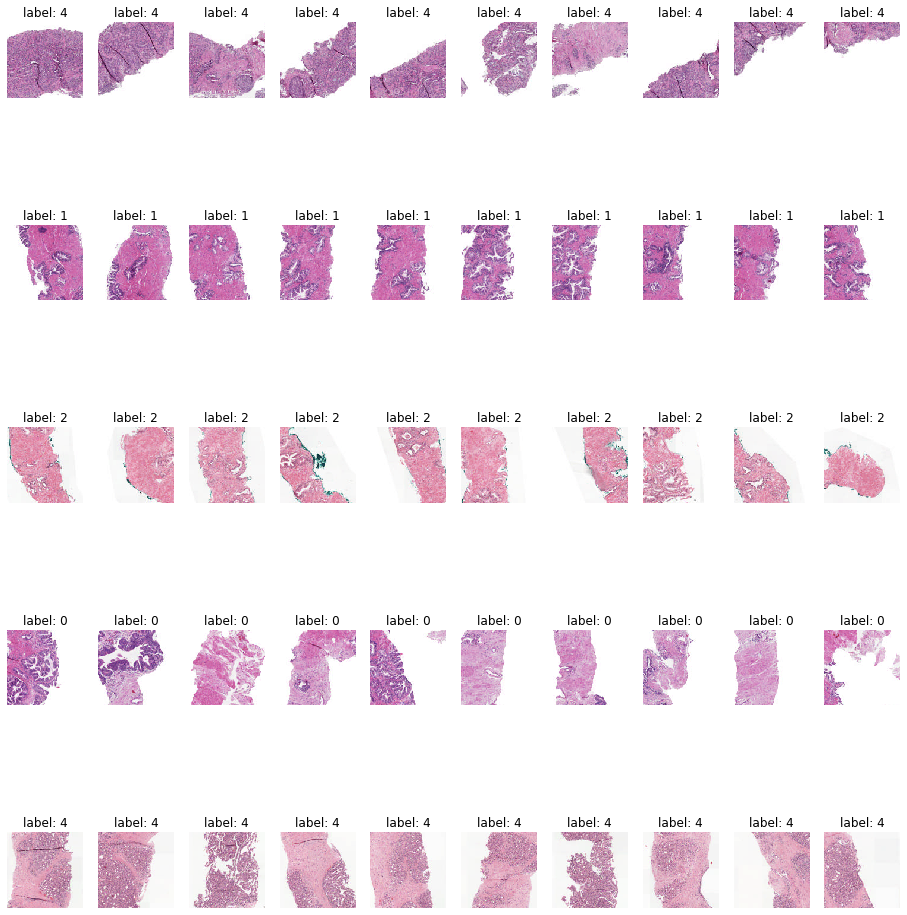

In [12]:
data.display_batch()

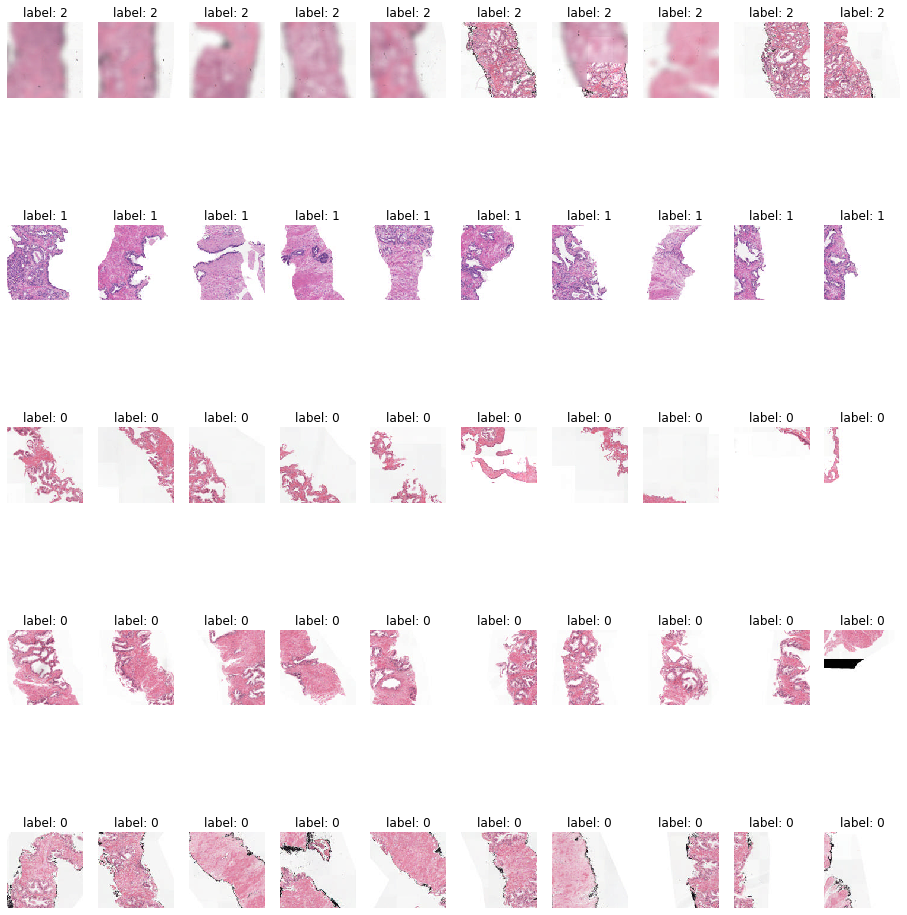

In [13]:
val_data.display_batch()

## Keras method

In [14]:
def backend_reshape(x, new_shape):
    # casting a shape (bs, N, w/N, H, C) with batch shape None:
    # (-1,N,w/N, H, C), -1 handles the None argument
    return K.reshape(x, new_shape)

In [18]:
inputs = KL.Input(shape=(NUM_TILES,128,128,3), batch_size=None)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, 128, 128, 3)})(inputs)


eff_net = tf.keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')(x)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, NUM_TILES, 4, 4, 2048)})(eff_net)
x = KL.Reshape((NUM_TILES * 4, 4, 2048))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.9)(x)
x = tf.keras.layers.Dense(units=512, kernel_initializer='he_normal', activation='relu')(x)
outputs = KL.Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

fake_val = data()

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', CohenKappa(num_classes=NUM_CLASSES, weightage='quadratic', name='qwk')])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16, 128, 128, 3)] 0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
lambda_5 (Lambda)            (None, 16, 4, 4, 2048)    0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 4, 2048)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [19]:
model.fit(data(), steps_per_epoch=STEPS_PER_EPOCH, 
          epochs = NUM_EPOCHS, 
          validation_data=val_data(mode='validation'),
          validation_steps= int(valid_df.shape[0] / BATCH_SIZE))

skipping shuffling operations in validation generator
Epoch 1/15
525/525 [==============================] - 461s 878ms/step - loss: 2.7793 - accuracy: 0.2808 - qwk: 0.2808 - val_loss: 1.7946 - val_accuracy: 0.2543 - val_qwk: -0.0422
Epoch 2/15
  1/525 [..............................] - 73s 73s/step - loss: 3.8260 - accuracy: 0.1667 - qwk: 0.5489 - val_loss: 1.7942 - val_accuracy: 0.2476 - val_qwk: -0.0601


In [ ]:
valid_df.shape[0] / BATCH_SIZE

## Attempt at chaining models using tensorflow.gradienttape

In [12]:
def build_model():
    stage1_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    
    input_layer = tf.keras.layers.Input(shape=(4, 4 * NUM_TILES, stage1_model.output_shape[-1]))
    x = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(units=512, kernel_initializer='he_normal', activation='relu')(x)
    cls_head = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')(x)
    
    stage2_model = tf.keras.models.Model(inputs=[input_layer], outputs=[cls_head])
    return stage1_model, stage2_model, stage1_model.output_shape[-1]

In [13]:
stage1_model, stage2_model, stage1_channels = build_model()

In [14]:
print(stage1_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)
train_loss = tf.keras.metrics.Sum()
valid_loss = tf.keras.metrics.Sum()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [16]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as stage1_tape, tf.GradientTape() as stage2_tape:
        images = tf.reshape(images, (-1, 128, 128, 3))
        stage1_output = stage1_model(images, training=True)

        stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
        stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3, 4))
        stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
        stage2_output = stage2_model(stage1_output, training=True)
        
        loss = loss_fn(labels, stage2_output)
        
    stage1_grads = stage1_tape.gradient(loss, stage1_model.trainable_variables)
    stage2_grads = stage2_tape.gradient(loss, stage2_model.trainable_variables)
    
    optimizer.apply_gradients(zip(stage1_grads, stage1_model.trainable_variables))
    optimizer.apply_gradients(zip(stage2_grads, stage2_model.trainable_variables))
    
    train_loss.update_state(loss)
    train_accuracy.update_state(labels, tf.math.argmax(stage2_output, axis=1))
    
def valid_step(images, labels):
    images = tf.reshape(images, (-1, 128, 128, 3))
    stage1_output = stage1_model(images, training=False)

    stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
    stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3,4))
    stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
    stage2_output = stage2_model(stage1_output, training=False)
    
    loss = loss_fn(labels, stage2_output)
    valid_loss.update_state(loss)
    valid_accuracy.update_state(labels, tf.math.argmax(stage2_output, axis=1))
    
    return stage2_output.numpy()

def inference_step(images):
    images = tf.reshape(images, (-1, 128, 128, 3))
    stage1_output = stage1_model(images, training=False)
    stage1_output = tf.reshape(stage1_output, (-1, NUM_TILES, 4, 4, stage1_channels))
    stage1_output = tf.transpose(stage1_output, (0, 2, 1, 3, 4))
    stage1_output = tf.reshape(stage1_output, (-1, 4, 4*NUM_TILES, stage1_channels))
    stage2_output = stage2_model(stage1_output, training=False)
    
    return stage2_output.numpy()    

In [17]:
best_valid_qwk = 0
history = {
    'train_loss' : [],
    'valid_loss' : [],
    'train_accuracy' : [],
    'valid_accuracy' : [],
    'qwk' : []
}

TRAIN_FLAG=True

In [19]:
if TRAIN_FLAG:

    print("Steps per epoch:", STEPS_PER_EPOCH, "Valid steps per epoch:", VALIDATION_STEPS)
    epoch = 0
    for epoch in range(NUM_EPOCHS):
        print("Epoch {} / {}".format(epoch, NUM_EPOCHS))
        start_time = time.time()
        #model training
        
        for step, (images, labels) in  enumerate(data()):
            train_step(images, labels)
            #print('=', end='', flush=True)
            print("step: {} / {}, training loss {:04f}".format(step, 
                                                           STEPS_PER_EPOCH, 
                                                           train_loss.result().numpy() / step), flush=True, end='\r')
        
        #model validation
        predictions = []
        groundtruths = []

        for v_step, (images, labels) in enumerate(val_data(mode='validation')):
            valid_preds = valid_step(images, labels)
            valid_preds = np.argmax(valid_preds, axis=-1)
            groundtruths += list(labels)
            predictions += list(valid_preds)
            if v_step % 10 == 0:
                print('=', end='', flush=True)
        


        groundtruths = np.argmax(np.array(groundtruths), axis=1)
        
        print(predictions[0:100])
        print(groundtruths[0:100])
        qwk = cohen_kappa_score(groundtruths, predictions, labels=None, weights= 'quadratic', sample_weight=None)

        history['train_loss'].append(train_loss.result().numpy() / STEPS_PER_EPOCH)
        history['valid_loss'].append(valid_loss.result().numpy() / VALIDATION_STEPS)
        history['train_accuracy'].append(train_accuracy.result().numpy())
        history['valid_accuracy'].append(valid_accuracy.result().numpy())
        history['qwk'].append(qwk)

        print('\nEPOCH {:d}/{:d}'.format(epoch+1, NUM_EPOCHS))
        print('loss: {:0.4f}'.format(history['train_loss'][-1]),'val_loss: {:0.4f}'.format(history['valid_loss'][-1]))
        print('accuracy : {}'.format(history['train_accuracy'][-1]), 'val_accuracy : {}'.format(history['valid_accuracy'][-1]))
        print('validation qwk : {}'.format(qwk))

        # set up next epoch
        valid_loss.reset_states()
        train_loss.reset_states()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()


        if history['qwk'][-1] > best_valid_qwk:
            print('Validation qwk improve from {} to {}, save model checkpoint'.format(best_valid_qwk, history['qwk'][-1]))
            stage1_model.save('stage1.h5')
            stage2_model.save('stage2.h5')
            best_valid_qwk = history['qwk'][-1]

        print('Spending time : {}...'.format(time.time()-start_time))

Steps per epoch: 525 Valid steps per epoch: 131
Epoch 0 / 15


/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


skipping shuffling operations in validation generator
==============[5, 5, 4, 5, 0, 2, 5, 0, 0, 0, 2, 1, 5, 5, 0, 5, 0, 0, 4, 3, 4, 0, 5, 1, 5, 5, 1, 5, 0, 4, 5, 0, 0, 1, 0, 4, 5, 1, 0, 5, 5, 5, 4, 0, 3, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 2, 0, 0, 5, 0, 5, 0, 0, 0, 0, 5, 5, 0, 1, 0, 5, 5, 3, 4, 0, 1, 4, 4, 4, 4, 5, 0, 5, 3, 0, 5, 4, 4, 5, 5, 4, 0, 4, 5, 5, 5, 0]
[4 3 2 5 0 2 4 0 3 1 2 2 3 4 0 4 0 1 2 2 4 3 5 5 4 5 1 5 2 5 5 3 0 1 0 5 5
 1 1 5 3 4 4 1 1 3 0 3 1 5 2 5 5 1 0 4 3 1 3 0 2 4 1 5 1 1 1 3 5 3 2 1 0 5
 5 1 3 0 0 2 5 1 3 5 1 5 2 1 3 3 3 5 4 3 1 4 5 4 5 0]

EPOCH 1/15
loss: 1.1697 val_loss: 1.5837
accuracy : 0.1136886328458786 val_accuracy : 0.2009478658437729
validation qwk : 0.6497406201523401
Spending time : 478.2943603992462...
Epoch 1 / 15
skipping shuffling operations in validation generator
==============[4, 5, 0, 5, 0, 3, 4, 0, 4, 0, 2, 3, 4, 4, 0, 3, 0, 2, 4, 2, 4, 4, 3, 4, 4, 5, 1, 4, 4, 4, 4, 1, 4, 0, 0, 4, 4, 1, 1, 5, 4, 4, 4, 0, 2, 4, 0, 4, 0, 4, 1, 0, 4, 0, 0, 4

KeyboardInterrupt: 

## Quick experiences:

1. Using Max pooling instead of just Dense layers slows down training. At this moment idk if it is the network, whether it will be better when run for more epochs, or why this is happening
2. The 'batch hack' seems to work just fine and the model is learning.
3. QWK cohenkappa of tensorflow addons is a stateful metric :)
